In [269]:
%matplotlib inline
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable

In [270]:
from midox import midiread, midiwrite
# import pretty_midi
from matplotlib import pyplot as plt
import skimage.io as io
from IPython.display import FileLink

from utils import *

In [271]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DataLoader

In [272]:
trainset = NotesGenerationDataset('./classic/train/')

trainset_loader = Data.DataLoader(trainset, batch_size=1, shuffle=True, drop_last=True)

In [273]:
X = next(iter(trainset_loader))
X[0].shape

keys_shape = X[0].shape[2]

In [274]:
valset = NotesGenerationDataset('./classic/val/') # type: ignore

valset_loader = Data.DataLoader(valset, batch_size=1, shuffle=False, drop_last=False)

In [275]:
X_val = next(iter(valset_loader))
X_val[0].shape

torch.Size([1, 4405, 88])

# RNN

In [276]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers = 2, is_bidirect = False):
        super(lstm_encoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.is_bidirect = is_bidirect

        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        self.bn = nn.BatchNorm1d(hidden_size)

        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=is_bidirect)
        
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        notes_encoded = self.notes_encoder(input_sequences)
        
        notes_encoded_rolled = notes_encoded.permute(1,2,0).contiguous()
        notes_encoded_norm = self.bn(notes_encoded_rolled)
        
        notes_encoded_norm_drop = nn.Dropout(0.25)(notes_encoded_norm)
        notes_encoded_complete = notes_encoded_norm_drop.permute(2,0,1)
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded_complete, input_sequences_lengths)
        outputs, hidden = self.gru(packed, hidden)
        return hidden

In [277]:
class lstm_decoder(nn.Module):
    def __init__(self, hidden_size, num_classes, n_layers = 2, is_bidirect = False):
        super(lstm_decoder, self).__init__()

        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        self.is_bidirect = is_bidirect

        self.notes_decoder = nn.Linear(in_features=hidden_size, out_features=num_classes)
        
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=is_bidirect)
        
    def forward(self, hidden_vector, batch_size=1):
        decoder_input = torch.empty(batch_size, 1, self.hidden_size, dtype=torch.float, device=device).fill_(0)
        decoder_hidden = hidden_vector
        decoder_outputs = []

        for i in range(1):
            # print(decoder_input.shape, decoder_hidden[0].shape, decoder_hidden[1].shape)
            decoder_output, decoder_hidden = self.gru(decoder_input, decoder_hidden)
            decoder_output = nn.Dropout(0.25)(decoder_output)
            decoder_output = self.notes_decoder(decoder_output)
            decoder_outputs.append(decoder_output)
            decoder_input = decoder_input[:, i].unsqueeze(1)

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return decoder_outputs, decoder_hidden

In [278]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2, is_bidirect=False):
        super(RNN, self).__init__()
        
        self.encoder = lstm_encoder(input_size, hidden_size, n_layers, is_bidirect)
        self.decoder = lstm_decoder(hidden_size, num_classes, n_layers, is_bidirect)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        batch_size = input_sequences.shape[0]
        encoder_hidden = self.encoder(input_sequences, input_sequences_lengths, hidden)
        logits, decoder_hidden = self.decoder(encoder_hidden, batch_size)
        logits = logits.transpose(0, 1).contiguous()
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking,crossentropy is used
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        logits_flatten = binary_logits.view(-1, 2)
        return logits_flatten, decoder_hidden

In [279]:
model = RNN(input_size=keys_shape, hidden_size=512, num_classes=keys_shape).to(device)

criterion = nn.CrossEntropyLoss().to(device)
criterion_val = nn.CrossEntropyLoss().to(device)

In [280]:
validate(model, valset_loader, criterion_val)

100%|██████████| 59/59 [00:08<00:00,  6.85it/s]


1.579893549651557e-05

In [281]:
clip = 1.0
epochs_number = 10
sample_history = []
best_val_loss = float("inf")

In [282]:
def lrfinder(start, end, model, trainset_loader, epochs=2):
    model.train() # into training mode
    lrs = np.linspace(start, end, epochs*len(trainset_loader))
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(model.parameters(),start)
    loss_list = []
    ctr = 0
    
    for epoch_number in range(epochs):
        epoch_loss = []
        print('Epoch %d' % epoch_number)
        for batch in tqdm(trainset_loader):
            optimizer.param_groups[0]['lr'] = lrs[ctr]
            ctr = ctr+1

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple
            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).to(device))
            input_sequences_batch_var = Variable(input_sequences_batch.to(device))

            # fake = input_sequences_batch_var[:, 0:1, :]

            # plt.figure(figsize=(10,6))
            # plt.imshow(fake.cpu().numpy().reshape((fake.shape[0],88)).transpose(0,1))

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            epoch_loss.append(loss.item())
        
        print('Loss %.4f' % np.mean(epoch_loss))
    plt.plot(lrs, loss_list)
    return lrs, loss_list

Epoch 0


100%|██████████| 177/177 [00:37<00:00,  4.76it/s]


Loss 0.4648
Epoch 1


100%|██████████| 177/177 [00:37<00:00,  4.74it/s]

Loss 0.1590


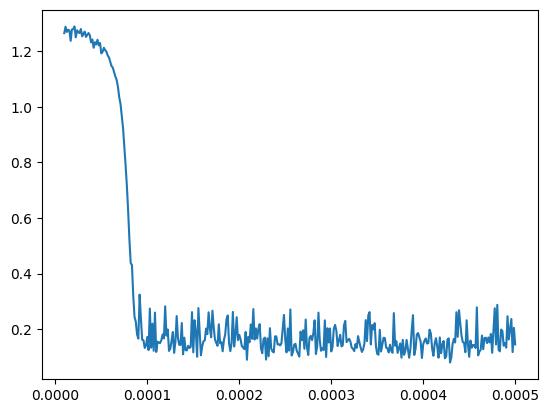

In [290]:
rnn = RNN(input_size=keys_shape, hidden_size=512, num_classes=keys_shape).to(device)
lrs, losses = lrfinder(1e-5, 5e-4, rnn, trainset_loader)

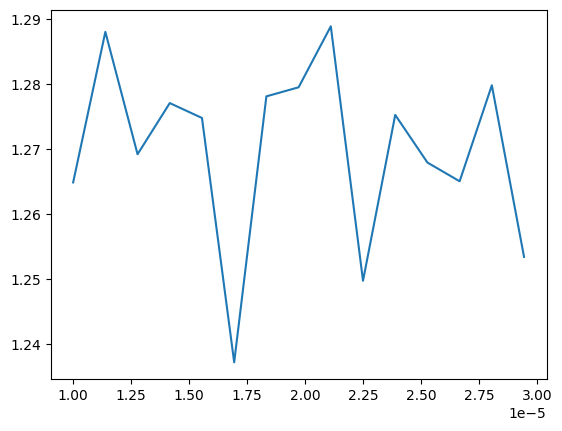

In [291]:
plt.plot(lrs[:15], losses[:15])

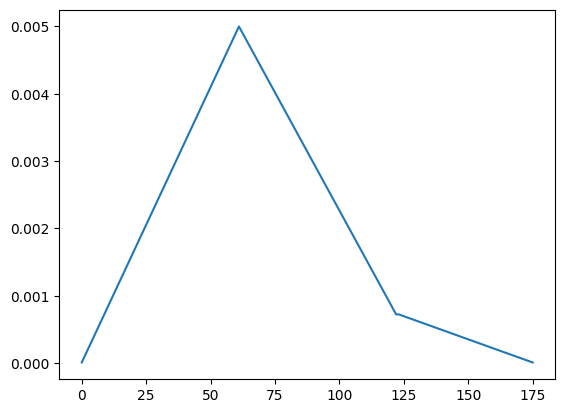

In [292]:
def get_triangular_lr(lr_low, lr_high, mini_batches):
    iterations = mini_batches
    lr_mid = lr_high/7 + lr_low
    up = np.linspace(lr_low, lr_high, int(round(iterations*0.35)))
    down = np.linspace(lr_high, lr_mid, int(round(iterations*0.35)))
    floor = np.linspace(lr_mid, lr_low, int(round(iterations*0.30)))
    return np.hstack([up, down[1:], floor])

lrs_triangular = get_triangular_lr(1e-5, 5e-3, len(trainset_loader))
plt.plot(lrs_triangular)

In [293]:
rnn = RNN(input_size=keys_shape, hidden_size=512, num_classes=keys_shape).to(device)
lrs_triangular = get_triangular_lr(1e-5, 5e-4, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, trainset_loader, criterion, valset_loader, criterion_val)

Epoch:  0


0it [00:00, ?it/s]

176it [00:35,  4.94it/s]


Training Loss: Epoch: 0 : 0.33664518590532455


100%|██████████| 59/59 [00:08<00:00,  7.00it/s]


Validation Loss: Epoch: 0 : 2.104189925114487e-06

Epoch:  1


176it [00:36,  4.88it/s]


Training Loss: Epoch: 1 : 0.157398355503877


100%|██████████| 59/59 [00:08<00:00,  6.74it/s]

Validation Loss: Epoch: 1 : 2.0856912514986156e-06



In [294]:
lrs_triangular = get_triangular_lr(1e-6, 1e-4, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, trainset_loader, criterion, valset_loader, criterion_val, epochs_number=2, wd=1e-4, best_val_loss=best_val_loss)

Epoch:  0


176it [00:36,  4.84it/s]


Training Loss: Epoch: 0 : 0.1545587438395468


100%|██████████| 59/59 [00:08<00:00,  6.71it/s]


Validation Loss: Epoch: 0 : 2.082109018909452e-06

Epoch:  1


176it [00:36,  4.78it/s]


Training Loss: Epoch: 1 : 0.15422047573631092


100%|██████████| 59/59 [00:08<00:00,  6.75it/s]

Validation Loss: Epoch: 1 : 2.08126344448853e-06



In [295]:
lrs_triangular = get_triangular_lr(1e-5, 1e-4, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, trainset_loader, criterion, valset_loader, criterion_val, epochs_number=2, wd=1e-4*5, best_val_loss=best_val_loss)

Epoch:  0


176it [00:36,  4.77it/s]


Training Loss: Epoch: 0 : 0.15396187812258294


100%|██████████| 59/59 [00:08<00:00,  6.79it/s]


Validation Loss: Epoch: 0 : 2.0743745520514217e-06

Epoch:  1


176it [00:36,  4.78it/s]


Training Loss: Epoch: 1 : 0.15353550677750744


100%|██████████| 59/59 [00:08<00:00,  6.67it/s]

Validation Loss: Epoch: 1 : 2.1128617331157053e-06



In [296]:
rnn.load_state_dict(torch.load('music_model_padfront_regularized.pth'))

<All keys matched successfully>

# Validation

In [297]:
def sample_from_piano_rnn(model, sample_length=4, temperature=1, starting_sequence=None):
    if starting_sequence is None:
        current_sequence_input = torch.zeros(1, 1, keys_shape)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.to(device))
    else:
        current_sequence_input = starting_sequence
        
    final_output_sequence = [current_sequence_input.data.squeeze(1)]

    hidden = None

    for i in range(sample_length + 10):
        output, hidden = model(current_sequence_input, [1], hidden)

        probabilities = nn.functional.softmax(output.divide(temperature), dim=1)
        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)
        current_sequence_input = Variable(current_sequence_input.float())
        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    sampled_sequence = torch.cat(final_output_sequence[10:], dim=0).cpu().numpy()
    
    return sampled_sequence

In [298]:
testset = NotesGenerationDataset('./classic/test/')

testset_loader = Data.DataLoader(testset, batch_size=1,shuffle=True, drop_last=False)

In [299]:
batch = next(iter(testset_loader))
post_processed_batch_tuple = post_process_sequence_batch(batch)

input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).to(device)

input_sequences_batch_var = input_sequences_batch.to(device)
input_sequences_batch_var.shape

torch.Size([1367, 1, 88])

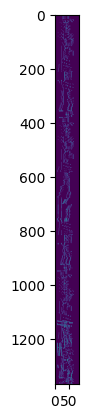

In [300]:
plt.imshow(input_sequences_batch_var.cpu().numpy().reshape((input_sequences_batch_var.shape[0],keys_shape)).transpose(0,1))

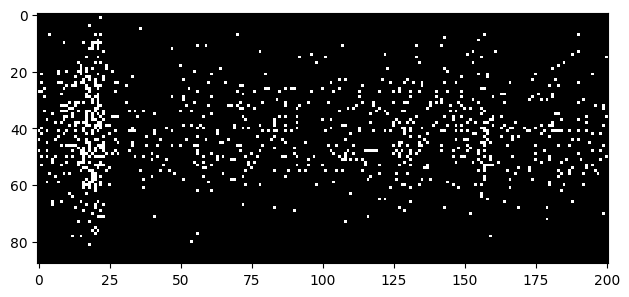

In [301]:
sample = sample_from_piano_rnn(rnn, sample_length=200, temperature=0.7, starting_sequence=X[0][:,:1,:].to(device)).transpose()
io.imshow(sample)
piano_roll = sample.transpose()

In [ ]:
midiwrite('output1.mid', piano_roll, dt=0.4)

# from pypianoroll import Multitrack, BinaryTrack
# piano_roll[:, 89:] = 0
# track_name = 'Piano'
# pianoroll_track = BinaryTrack(pianoroll=piano_roll, name=track_name)
# multitrack_name = 'MyMultitrack'  # Set a name for the multitrack
# multitrack = Multitrack(tracks=[pianoroll_track], name=multitrack_name, resolution=1)
# print(multitrack)
# multitrack.write('output.mid')

In [ ]:
FileLink('output.mid')

/home/bhavb/Dev/SMAI/project-team-1/ckpt2/output.mid

In [ ]:
# import IPython.display as ipd
# ipd.Audio('./sample_reg_018.mp3')